# Logistic regression Assumptions

- log-odds linearity
- multicollinearity
- outliers


## Data Loading


In [1]:
import pandas as pd
import matplotlib.pyplot as plt

from python_proj.utils.util import safe_save_fig, Counter
import python_proj.utils.exp_utils as exp_utils

file_name = "dataset_transformed"
base_path = exp_utils.BASE_PATH
data_path = f"{base_path}/final_data/{file_name}.csv"
experiment_name = "non_ftc_collaborative_logit_model"
figure_base_path = f"{base_path}/figures/modelling/{file_name}/{experiment_name}"

# Meta stuff.
pr_merged_key = "PullRequestIsMerged"
ftc_key = "SubmitterIsFirstTimeContributor"
seed_counter = Counter()


# Loads dataframe.
df: pd.DataFrame = pd.read_csv(filepath_or_buffer=data_path, header=0)

# Loads first-time contributor data frame.
print(f"{len(df)=}")
print(f"{len(df.columns)=}")

# Creates sub-datasets.
metadata_fields = ["ID", "Project Name", "Submitter ID", "PR Number", "Closed At"]
dependent_fields = [pr_merged_key]
independent_fields = [
    field
    for field in df.columns
    if (field not in metadata_fields and field not in dependent_fields)
]

df.describe()

len(df)=1216221
len(df.columns)=43


,ID,Submitter ID,PR Number,IntraProjectSubmitterPullRequestSuccessRate,EcosystemExperienceSubmitterPullRequestSuccessRate,DependencyEcosystemExperienceSubmitterPullRequestSuccessRate,NonDependencyEcosystemExperienceSubmitterPullRequestSuccessRate,InversedDependencyEcosystemExperienceSubmitterPullRequestSuccessRate,ln(1 + ControlPullRequestLifeTimeInMinutes),ln(1 + ControlNumberOfCommitsInPullRequest),...,ln(1 + DependencyEcosystemExperienceSubmitterIssueSubmissionCount),ln(1 + DependencyEcosystemExperienceSubmitterIssueCommentCount),ln(1 + NonDependencyEcosystemExperienceSubmitterIssueSubmissionCount),ln(1 + NonDependencyEcosystemExperienceSubmitterIssueCommentCount),ln(1 + InversedDependencyEcosystemExperienceSubmitterIssueSubmissionCount),ln(1 + InversedDependencyEcosystemExperienceSubmitterIssueCommentCount),ln(1 + WeightedEcosystemSecondOrderDegreeCentrality),ln(1 + WeightedIntraProjectSecondOrderDegreeCentrality),ln(1 + EcosystemLinkIntensity),ln(1 + IntraProjectLinkIntensity)
count,1.216221e+06,1.216221e+06,1.216221e+06,1.216221e+06,1.216221e+06,1.216221e+06,1.216221e+06,1.216221e+06,1.216221e+06,1.216221e+06,...,1.216221e+06,1.216221e+06,1.216221e+06,1.216221e+06,1.216221e+06,1.216221e+06,1.216221e+06,1.216221e+06,1.216221e+06,1.216221e+06
mean,1.473092e+08,5.092504e+06,8.089130e+02,5.029367e-01,4.028501e-01,9.853429e-02,3.751776e-01,5.922709e-02,4.195426e-01,1.183858e-01,...,1.144450e-02,1.968795e-02,7.962418e-02,1.344287e-01,9.542167e-03,1.752697e-02,6.396780e-02,6.040052e-02,2.195312e-02,4.472791e-02
std,9.954409e+07,7.968202e+06,2.304617e+03,4.710606e-01,4.523397e-01,2.907111e-01,4.479337e-01,2.285036e-01,2.256901e-01,7.147764e-02,...,5.396848e-02,8.007560e-02,1.179799e-01,1.750052e-01,5.263118e-02,8.245257e-02,9.934566e-02,1.002992e-01,8.741610e-02,1.013945e-01
min,6.870000e+02,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,5.924867e+07,4.674710e+05,5.000000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.365158e-01,7.525668e-02,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,1.366714e+08,1.633887e+06,1.990000e+02,6.800000e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,4.433349e-01,7.525668e-02,...,0.000000e+00,0.000000e+00,0.000000e+00,7.753347e-02,0.000000e+00,0.000000e+00,8.453635e-03,0.000000e+00,0.000000e+00,0.000000e+00
75%,2.260994e+08,6.254382e+06,6.840000e+02,1.000000e+00,9.391304e-01,0.000000e+00,9.230769e-01,0.000000e+00,5.863557e-01,1.505134e-01,...,0.000000e+00,0.000000e+00,1.416667e-01,2.326004e-01,0.000000e+00,0.000000e+00,9.892883e-02,8.837267e-02,0.000000e+00,2.582313e-02
max,3.617756e+08,5.973444e+07,8.297600e+04,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,...,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00


## FTC Data Selection

Sumbsamples the dataframe to only contains FTC data, and drops all columns that become obsolete in that scenario.

In [2]:
# Drops non-FTC data.

df = df[df[ftc_key] == False]
print(f"{len(df)=}")

len(df)=789389


In [3]:
# Drops irrelevant columns.

not_applicable_fields = [
    ftc_key,
    "IntraProjectSubmitterPullRequestSuccessRate",
    "ln(1 + IntraProjectSubmitterPullRequestSubmissionCount)",
]

df = df.drop(not_applicable_fields, axis=1)

independent_fields = [
    field for field in independent_fields if field not in not_applicable_fields
]

## Feature selection for collaborative model

Identifies all features that are not part of the collaborative model and drops those.

In [4]:
# Identifies the to-be-dropped features

from python_proj.utils.util import get_matching

has_eco_but_no_collab_pattern = (
    r"^(?!.*(?:LinkIntensity|DegreeCentrality))(?=.*Ecosystem).*"
)
dropped_fields = list(get_matching(independent_fields, has_eco_but_no_collab_pattern))

print(f"{len(dropped_fields)=}")
print(f"{dropped_fields=}")

len(dropped_fields)=20
dropped_fields=['EcosystemExperienceSubmitterPullRequestSuccessRate', 'DependencyEcosystemExperienceSubmitterPullRequestSuccessRate', 'NonDependencyEcosystemExperienceSubmitterPullRequestSuccessRate', 'InversedDependencyEcosystemExperienceSubmitterPullRequestSuccessRate', 'ln(1 + EcosystemExperienceSubmitterPullRequestSubmissionCount)', 'ln(1 + EcosystemExperienceSubmitterPullRequestCommentCount)', 'ln(1 + DependencyEcosystemExperienceSubmitterPullRequestSubmissionCount)', 'ln(1 + DependencyEcosystemExperienceSubmitterPullRequestCommentCount)', 'ln(1 + NonDependencyEcosystemExperienceSubmitterPullRequestSubmissionCount)', 'ln(1 + NonDependencyEcosystemExperienceSubmitterPullRequestCommentCount)', 'ln(1 + InversedDependencyEcosystemExperienceSubmitterPullRequestSubmissionCount)', 'ln(1 + InversedDependencyEcosystemExperienceSubmitterPullRequestCommentCount)', 'ln(1 + EcosystemExperienceSubmitterIssueSubmissionCount)', 'ln(1 + EcosystemExperienceSubmitterIssueComme

In [5]:
# Drops the selected features

df = df.drop(dropped_fields, axis=1)
independent_fields = [
    field for field in independent_fields if field not in dropped_fields
]

print(f"{len(df.columns)=}")
df.describe()

len(df.columns)=20


,ID,Submitter ID,PR Number,ln(1 + ControlPullRequestLifeTimeInMinutes),ln(1 + ControlNumberOfCommitsInPullRequest),ln(1 + ControlIntraProjectPullRequestExperienceOfIntegrator),ln(1 + IntraProjectSubmitterPullRequestCommentCount),ln(1 + IntraProjectSubmitterIssueSubmissionCount),ln(1 + IntraProjectSubmitterIssueCommentCount),ln(1 + WeightedEcosystemSecondOrderDegreeCentrality),ln(1 + WeightedIntraProjectSecondOrderDegreeCentrality),ln(1 + EcosystemLinkIntensity),ln(1 + IntraProjectLinkIntensity)
count,7.893890e+05,7.893890e+05,789389.000000,789389.000000,789389.000000,789389.000000,789389.000000,789389.000000,789389.000000,789389.000000,789389.000000,789389.000000,789389.000000
mean,1.613374e+08,5.071217e+06,929.996330,0.380645,0.124870,0.352489,0.218282,0.101701,0.187134,0.072195,0.088793,0.026830,0.065518
std,9.890446e+07,7.946069e+06,2552.602012,0.217298,0.075795,0.175332,0.194539,0.147167,0.206223,0.103604,0.111771,0.097241,0.119149
min,6.870000e+02,1.000000e+00,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,7.601776e+07,4.540660e+05,68.000000,0.198106,0.075257,0.214396,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.561170e+08,1.606068e+06,255.000000,0.393710,0.075257,0.352321,0.184663,0.000000,0.138687,0.020509,0.044760,0.000000,0.000000
75%,2.410351e+08,6.193135e+06,806.000000,0.545946,0.150513,0.479503,0.360730,0.165785,0.341859,0.114672,0.140823,0.000000,0.080350
max,3.617734e+08,5.943086e+07,82974.000000,1.000000,0.993928,1.000000,1.000000,1.000000,1.000000,0.922599,1.000000,1.000000,1.000000


## Log-odds linearity


### Visual checking


untransformed


ln(1 + ControlPullRequestLifeTimeInMinutes):
0.00    0.001063
0.25    0.198106
0.50    0.393710
0.75    0.545946
1.00    1.000000
Name: ln(1 + ControlPullRequestLifeTimeInMinutes), dtype: float64

x=[0.105400999588403, 0.2908704576739881, 0.4700002789567454, 0.6353177955413194], y=[2.4919747506869605, 2.43491356715749, 2.0438026880801927, 0.847083116143153]


ln(1 + ControlNumberOfCommitsInPullRequest):
0.00    0.075716
0.25    0.075716
0.50    0.075716
0.75    0.151433
1.00    1.000000
Name: ln(1 + ControlNumberOfCommitsInPullRequest), dtype: float64

x=[0.07571646583867965, 0.07571646583867965, 0.07571646583867965, 0.1957242248801215], y=[1.7976265149141584, 1.7976265149141584, 1.8330056438976494, 1.7398232866995975]


ln(1 + ControlIntraProjectPullRequestExperienceOfIntegrator):
0.00    0.082940
0.25    0.232841
0.50    0.364297
0.75    0.483777
1.00    1.000000
Name: ln(1 + ControlIntraProjectPullRequestExperienceOfIntegrator), dtype: float64

x=[0.1658790682037577, 0.2973351195825193, 0.4219517978139241, 0.5613500546126379], y=[1.201686718014688, 1.7285099070480399, 2.3732757509597633, 2.7527079601276716]


ln(1 + IntraProjectSubmitterPullRequestCommentCount):
0.00    0.092332
0.25    0.184663
0.50    0.292685
0.75    0.417668
1.00    1.000000
Name: ln(1 + IntraProjectSubmitterPullRequestCommentCount), dtype: float64

x=[0.1463422995519317, 0.2386740105453123, 0.3515395943126481, 0.5070721929084143], y=[1.738800225035642, 1.9693868867820317, 2.1237666673894813, 2.04386050334551]


ln(1 + IntraProjectSubmitterIssueSubmissionCount):
0.00    0.104599
0.25    0.104599
0.50    0.209198
0.75    0.331571
1.00    1.000000
Name: ln(1 + IntraProjectSubmitterIssueSubmissionCount), dtype: float64

x=[0.1045988688198613, 0.1045988688198613, 0.2428710522062736, 0.4183954752794452], y=[1.793258391437927, 1.8713116262020342, 2.1346142950638103, 2.264736368853761]


ln(1 + IntraProjectSubmitterIssueCommentCount):
0.00    0.087502
0.25    0.175003
0.50    0.313690
0.75    0.448821
1.00    1.000000
Name: ln(1 + IntraProjectSubmitterIssueCommentCount), dtype: float64

x=[0.1386867824227932, 0.2456480964576827, 0.3781756988382231, 0.5381128199120686], y=[1.8082295804313355, 1.9968220090726005, 2.1890303934471835, 2.1714966400488622]


ln(1 + WeightedEcosystemSecondOrderDegreeCentrality):
0.00    0.001029
0.25    0.041025
0.50    0.101765
0.75    0.190513
1.00    1.000000
Name: ln(1 + WeightedEcosystemSecondOrderDegreeCentrality), dtype: float64

x=[0.017605161136322486, 0.06886838819901596, 0.1406810419580126, 0.2698786701680117], y=[1.8285477284241944, 1.8971991426473414, 1.9428655881154457, 2.0532465338473407]


ln(1 + WeightedIntraProjectSecondOrderDegreeCentrality):
0.00    0.000852
0.25    0.040798
0.50    0.098760
0.75    0.188399
1.00    1.000000
Name: ln(1 + WeightedIntraProjectSecondOrderDegreeCentrality), dtype: float64

x=[0.0187708786178499, 0.0670717218210819, 0.1372731074320199, 0.2661242852113767], y=[1.8213523040697395, 1.7712926344202349, 1.858818263450684, 1.932293167903779]


ln(1 + EcosystemLinkIntensity):
0.0    0.012088
0.5    0.190567
1.0    1.000000
Name: ln(1 + EcosystemLinkIntensity), dtype: float64

x=[0.081233052832877, 0.3571697760735505], y=[2.0497675526509744, 2.445072182325507]


ln(1 + IntraProjectLinkIntensity):
0.0    0.009608
0.5    0.146463
1.0    1.000000
Name: ln(1 + IntraProjectLinkIntensity), dtype: float64

x=[0.0648432080740566, 0.26456806550156164], y=[1.7394930945954645, 2.1412930184866603]


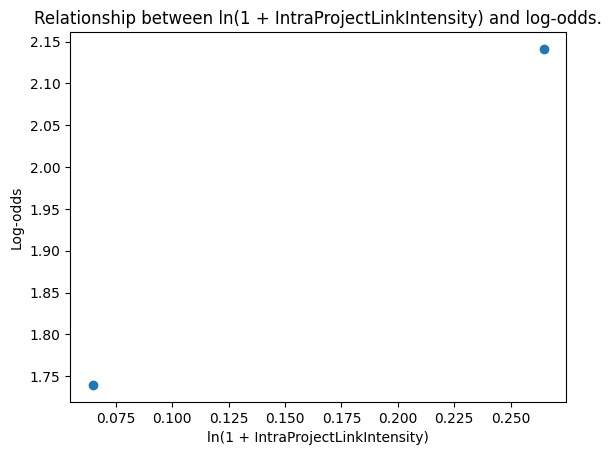

In [6]:
import regex as re
from numbers import Number
from typing import Callable, Iterator
import numpy as np
from python_proj.utils.util import tuple_chain


def test_log_linearity(
    independents: pd.DataFrame, dependent: pd.Series, transform_title: str = ""
):
    continuous_fields = independents.select_dtypes(include="number")

    all_data = pd.DataFrame()
    all_data[continuous_fields.columns] = continuous_fields.copy()
    all_data[pr_merged_key] = dependent.copy()

    for field in continuous_fields.columns:
        # Creates copy of the relevant fields.
        included = pd.DataFrame()
        included[field] = all_data[field].copy()
        included[pr_merged_key] = all_data[pr_merged_key].copy()

        # Removes data that will signifcantly skew the results.
        if re.match(r".*SuccessRate.*", field):
            # TODO: Figure out what to do with success rate.
            # We can't properly test the log-linearity with the current data.
            # count_field = field[:-len('SuccessRate')] + "SubmissionCount"
            stripped_field = field[: -len("SuccessRate")]
            count_field = f"ln(1 + {stripped_field}SubmissionCount)"
            included[count_field] = all_data[count_field].copy()
            included = included[included[count_field] > 0]
            perc_quantiles = [0, 0.1, 0.25, 0.4, 0.5, 0.6, 0.75, 0.9, 1]
        elif re.match(r".*LinkIntensity.*", field):
            included = included[included[field] > 0]
            perc_quantiles = [0, 0.5, 1]
        else:
            included = included[included[field] > 0]
            perc_quantiles = [0, 0.25, 0.5, 0.75, 1]

        # Calculates quantiles.
        quantiles = included[field].quantile(perc_quantiles)
        print(f"{field}:")
        print(quantiles)
        print()

        x = []
        y = []
        skip_flag = False
        for r_start, r_end in tuple_chain(list(quantiles)):
            quant_data: pd.DataFrame = included[
                (included[field] >= r_start) & (included[field] <= r_end)
            ]
            # quant_mean = quant_data[field].mean()
            quant_mean = quant_data[field].median()
            merged_entries = quant_data[quant_data[pr_merged_key] == True]
            probability = len(merged_entries) / len(quant_data)
            if probability == 1:
                skip_flag = True
                break
            log_odds = np.log(probability / (1 - probability))
            x.append(quant_mean)
            y.append(log_odds)

        if skip_flag:
            print(f"Skipped {field} because of division by zero.")
            continue

        print(f"{x=}, {y=}")

        plt.clf()
        plt.scatter(x, y)
        plt.title(f"Relationship between {field} and log-odds.")
        plt.xlabel(field)
        plt.ylabel("Log-odds")

        output_path = (
            f"{figure_base_path}/log-odds-independence/{transform_title}/{field}"
        )
        safe_save_fig(output_path)


def scale(_df: pd.DataFrame, scaled_fields: pd.Series):
    scaled_df = _df.copy()

    for feature in scaled_fields:
        feature_min = scaled_df[feature].min()
        feature_max = scaled_df[feature].max()
        feature_delta = feature_max - feature_min

        scaled_df[feature] = (
            scaled_df[feature].subtract(feature_min).divide(feature_delta)
        )

    return scaled_df


def test_log_linearity_with_transforms(
    transforms: Iterator[Callable[[Number], Number]],
    independents: pd.DataFrame,
    dependent: pd.Series,
    figure_subfolder: str,
):
    continuous_fields = independents.select_dtypes(include="number")
    for transform in transforms:
        print(f"\n{transform.__name__}")
        transformed_independents = continuous_fields.copy()
        for field in transformed_independents.columns:
            transformed_independents[field] = transformed_independents[field].apply(
                transform
            )
            transformed_independents = scale(transformed_independents, [field])

        test_log_linearity(
            transformed_independents,
            dependent,
            f"{figure_subfolder}/{transform.__name__}",
        )


def untransformed(value):
    return value


def ln_transform(value):
    return np.log(1 + value)


def sqrt_transform(value):
    return np.sqrt(1 + value)


def cbrt_transform(value):
    return np.cbrt(1 + value)


def reciprocal_transform(value):
    return 1 / (1 + value)


def squared_transform(value):
    return value**2


def ln_ln_transform(value):
    return np.log(1 + np.log(1 + value))


def ln_eps_transform(value):
    return np.log(0.1 + value)


def ln_eps_e2_transform(value):
    return np.log(0.01 + value)


def ln_eps_e3_transform(value):
    return np.log(0.001 + value)


def cubed_transform(value):
    return value**3


def ln_complement(value):
    return np.log(1.0 + (1.0 - value))


def ln_eps_complement(value):
    return np.log(0.001 + (1.0 - value))


def ln_eps_e5_complement(value):
    return np.log(0.00001 + (1.0 - value))


def compl_squared_compl(value):
    return 1.0 - ((1.0 - value) ** 2)


transforms = [
    untransformed,
    # ln_transform,
    # sqrt_transform,
    # cbrt_transform,
    # reciprocal_transform,
    # ln_complement,
    # ln_eps_complement,
    # compl_squared_compl,
    # squared_transform,
    # cubed_transform,
    # ln_ln_transform,
    # ln_eps_e2_transform,
    # ln_eps_e3_transform,
    # ln_eps_e5_complement
]


# Full model.
independents = df[independent_fields]
dependent = df[pr_merged_key]
test_log_linearity_with_transforms(
    transforms, independents, dependent, figure_subfolder=""
)

## Multicolinearity


### Dropped fields

The following are fields that were dropped to tackle multicollinearity.
The following two subsections: variance inflation factor, and spearman correlation were used to identify the features that were removed.

In [7]:
# Standardized list of multicollinear fields.
multicollinear_fields = [
    # Confounding variable
    "ln(1 + ControlIntraProjectPullRequestExperienceOfIntegrator)",
    # Link intensity
    "ControlIntegratedBySameUser",
    "ln(1 + IntraProjectLinkIntensity)",
    # Controls
    # "ControlPullRequestHasCommentByExternalUser",
    # "ControlPullRequestHasComments",
    # intra experience
    "ln(1 + IntraProjectSubmitterIssueCommentCount)",
    # "ln(1 + IntraProjectSubmitterIssueSubmissionCount)",
    "ln(1 + IntraProjectSubmitterPullRequestCommentCount)",
]

print(
    f"Removing {len(multicollinear_fields)} / {len(independent_fields)} fields to account for multicollinearity."
)

Removing 5 / 14 fields to account for multicollinearity.


In [8]:
# Drops fields.

logit_df = df[independent_fields].drop(multicollinear_fields, axis=1)

print(f"{len(logit_df)=}")
print(f"{len(logit_df.columns)=}")
print(f"{logit_df.columns=}")

len(logit_df)=789389
len(logit_df.columns)=9
logit_df.columns=Index(['ControlPullRequestHasComments',
       'ControlPullRequestHasCommentByExternalUser',
       'ControlHasHashTagInDescription',
       'ln(1 + ControlPullRequestLifeTimeInMinutes)',
       'ln(1 + ControlNumberOfCommitsInPullRequest)',
       'ln(1 + IntraProjectSubmitterIssueSubmissionCount)',
       'ln(1 + WeightedEcosystemSecondOrderDegreeCentrality)',
       'ln(1 + WeightedIntraProjectSecondOrderDegreeCentrality)',
       'ln(1 + EcosystemLinkIntensity)'],
      dtype='object')


### Variance Inflation Factor

The following identify problematic features using VIF.

In [9]:
# Replaces binary values with numeric variants so VIF can be calculated.

from statsmodels.stats.outliers_influence import variance_inflation_factor

value_mapper = {False: 0, True: 1}

binary_fields = logit_df.select_dtypes(exclude="number")
print(f"{len(binary_fields.columns)=}")
for feature in binary_fields:
    logit_df[feature] = logit_df[feature].replace(value_mapper)

len(binary_fields.columns)=3


In [10]:
# Calculates VIF

vif_df = pd.DataFrame()
vif_df["variable"] = logit_df.columns
vif_df["VIF"] = [
    variance_inflation_factor(logit_df.values, i) for i in range(logit_df.shape[1])
]

print(vif_df)

                                            variable       VIF
0                      ControlPullRequestHasComments  3.604119
1         ControlPullRequestHasCommentByExternalUser  2.107965
2                     ControlHasHashTagInDescription  1.616368
3        ln(1 + ControlPullRequestLifeTimeInMinutes)  3.954816
4        ln(1 + ControlNumberOfCommitsInPullRequest)  2.982025
5  ln(1 + IntraProjectSubmitterIssueSubmissionCount)  1.622995
6  ln(1 + WeightedEcosystemSecondOrderDegreeCentr...  1.512436
7  ln(1 + WeightedIntraProjectSecondOrderDegreeCe...  1.763049
8                     ln(1 + EcosystemLinkIntensity)  1.182720


In [11]:
# Identifies problematic fields, according to VIF.

VIF_THRESHOLD = 5

problematic_vif = vif_df[vif_df["VIF"] >= VIF_THRESHOLD]

print(f"{VIF_THRESHOLD}")
print(f"Problematic VIF fields: {len(problematic_vif)}.")
print("Problematic VIF scores:\n", problematic_vif)

5
Problematic VIF fields: 0.
Problematic VIF scores:
 Empty DataFrame
Columns: [variable, VIF]
Index: []


### Spearman Correlation

The following calculates the pairwise spearman correlation, to identify what problematic (groups of) features are.

In [12]:
# Calculates Spearman correlation between variables.

import json

corr = logit_df.corr(method="spearman")
coof_threshold = 0.5
print(f"{coof_threshold=}")

correlating_fields = []
for rowIndex, row in corr.iterrows():
    for columnIndex, coof in row.items():
        if columnIndex <= rowIndex:
            continue
        if abs(coof) < coof_threshold:
            continue
        correlating_fields.append([columnIndex, rowIndex, coof])
correlating_fields = [list(entry) for entry in correlating_fields]

print("Correlating pairs:\n", json.dumps(correlating_fields, indent=2))

coof_threshold=0.5
Correlating pairs:
 [
  [
    "ControlPullRequestHasComments",
    "ControlPullRequestHasCommentByExternalUser",
    0.576284403015395
  ]
]


In [13]:
# Generates transitive closure of correlating fields;
# i.e., it identifies clusters of correlating features.

from typing import List, Set

transitive_closures: List[Set[str]] = []

# Iterates through all correlating fields.
for field_a, field_b, _ in correlating_fields:
    was_added = False
    # Sees if one of the components is part of a transitive closure.
    for transitive_closure in transitive_closures:
        if field_a in transitive_closure or field_b in transitive_closure:
            was_added = True
            transitive_closure.update((field_a, field_b))
    # Adds new closure if they are not.
    if not was_added:
        new_set = set()
        new_set.update((field_a, field_b))
        transitive_closures.append(new_set)

# Prepares the closures to be printed.
transitive_closures = [sorted(list(closure)) for closure in transitive_closures]

print(
    "Transitive closure of correlating pairs:\n",
    json.dumps(transitive_closures, indent=2),
)

Transitive closure of correlating pairs:
 [
  [
    "ControlPullRequestHasCommentByExternalUser",
    "ControlPullRequestHasComments"
  ]
]


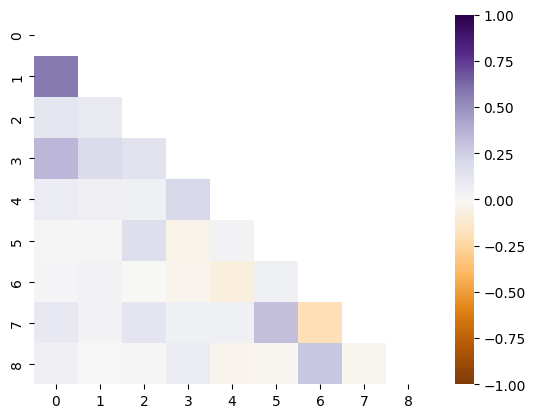

In [14]:
# Plots correlation as seaborn plot.

import seaborn as sb

tick_labels = list(range(len(vif_df)))
rows, cols = corr.shape
mask = np.invert(np.tril(np.ones((rows, cols), dtype=bool), k=-1))
dataplot = sb.heatmap(
    corr,
    cmap="PuOr",
    xticklabels=tick_labels,
    yticklabels=tick_labels,
    mask=mask,
    vmin=-1,
    vmax=1,
)

[[0, "ControlPullRequestHasComments"], [1, "ControlPullRequestHasCommentByExternalUser"], [2, "ControlHasHashTagInDescription"], [3, "ln(1 + ControlPullRequestLifeTimeInMinutes)"], [4, "ln(1 + ControlNumberOfCommitsInPullRequest)"], [5, "ln(1 + IntraProjectSubmitterIssueSubmissionCount)"], [6, "ln(1 + WeightedEcosystemSecondOrderDegreeCentrality)"], [7, "ln(1 + WeightedIntraProjectSecondOrderDegreeCentrality)"], [8, "ln(1 + EcosystemLinkIntensity)"]]


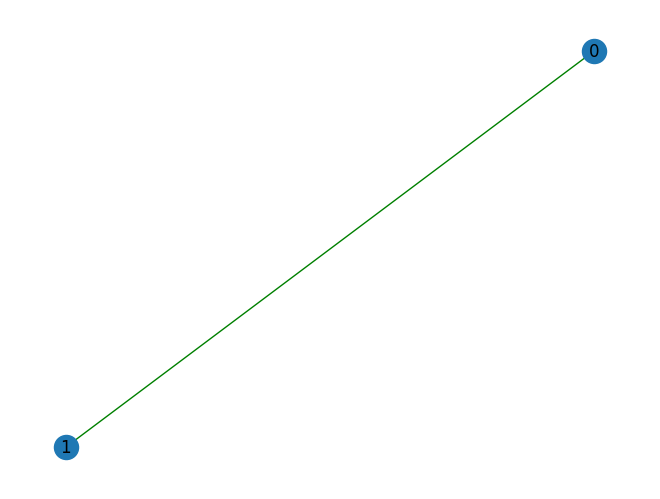

In [15]:
# Plots correlations as a graph.

import networkx as nx
import matplotlib.pyplot as plt

fields = list(logit_df.columns)
enumerated_list = list(enumerate(fields))
ids = []
edge_colors = []
for source, target, coof in correlating_fields:
    source_idx = fields.index(source)
    target_idx = fields.index(target)
    ids.append((source_idx, target_idx))
    edge_colors.append("red" if coof < 0 else "green")

# Create an empty graph
graph = nx.Graph()

# Add edges to the graph from the list of tuples
graph.add_edges_from(ids)

pos = nx.spring_layout(graph, k=0.4)
nx.draw(graph, pos, with_labels=True, edge_color=edge_colors)

if len(correlating_fields) == 0:
    print("When there are no correlating fields, the figure is supposed to be empty.")

output_path = f"{figure_base_path}/correlating_fields.png"
safe_save_fig(output_path)

print(json.dumps(enumerated_list))

## Outliers

Using cook's distance.


In [16]:
import statsmodels.api as sm
import scipy

X_constant = sm.add_constant(logit_df)

# Use GLM method for logreg here so that we can retrieve the influence measures
logit_results = sm.GLM(
    df[pr_merged_key], X_constant, family=sm.families.Binomial()
).fit()

# Get influence measures
influence = logit_results.get_influence()

# Obtain summary df of influence measures
summ_df = influence.summary_frame()

# Filter summary df to Cook's distance values only
diagnosis_df = summ_df[["cooks_d"]]

# Set Cook's distance threshold
cook_threshold = 4 / len(logit_df)

# Append absolute standardized residual values
diagnosis_df["std_resid"] = scipy.stats.zscore(logit_results.resid_pearson)
diagnosis_df["std_resid"] = diagnosis_df["std_resid"].apply(lambda x: np.abs(x))

# Find observations which are BOTH outlier (std dev > 3) and highly influential
extreme = diagnosis_df[
    (diagnosis_df["cooks_d"] > cook_threshold) & (diagnosis_df["std_resid"] > 3)
]


# Show top 5 highly influential outlier observations
extreme.sort_values("cooks_d", ascending=False).head(10)

/tmp/ipykernel_30151/2984006829.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  diagnosis_df["std_resid"] = scipy.stats.zscore(logit_results.resid_pearson)


/tmp/ipykernel_30151/2984006829.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  diagnosis_df["std_resid"] = diagnosis_df["std_resid"].apply(lambda x: np.abs(x))


,cooks_d,std_resid
629936,0.000199,4.397893
619787,0.000164,5.316270
619786,0.000164,5.324394
619783,0.000163,5.249642
1049030,0.000163,3.475165
619760,0.000162,5.304349
619788,0.000161,5.324498
619771,0.000161,5.123389
291294,0.000159,4.676770
1094044,0.000154,3.218196


cook_threshold=5.0672744017765864e-06
Found outliers: 20470 / 789389 (2.593%)


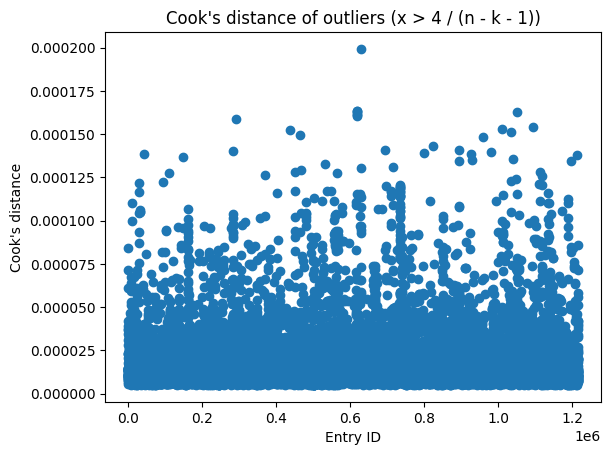

In [17]:
cook_threshold = 4 / (len(logit_df) - len(logit_df.columns) - 1)
print(f'{cook_threshold=}')
print(
    f"Found outliers: {len(extreme)} / {len(logit_df)} ({100 * len(extreme)/len(logit_df):.03f}%)"
)

plt.title("Cook's distance of outliers (x > 4 / (n - k - 1))")
plt.scatter(extreme.index, extreme["cooks_d"])
plt.xlabel("Entry ID")
plt.ylabel("Cook's distance")

output_path = f"{figure_base_path}/cooks_outliers.png"
safe_save_fig(output_path)

Removes outliers

In [18]:
logit_df = logit_df.drop(extreme.index)
tested_dependents = dependent.drop(extreme.index)

print(f"{len(logit_df)=}")

len(logit_df)=768919


# Model Creation

Creates a simple mixed effect logistic regression model.

In [19]:
from statsmodels.regression.mixed_linear_model import MixedLM

# Selects relevant project names.
pn_key = "Project Name"
tested_projects = df[pn_key].copy()
tested_projects = tested_projects[logit_df.index]

# Creates model.
mixed_model = MixedLM(
    tested_dependents,
    logit_df,
    tested_projects,
).fit()

mixed_model.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                               Mixed Linear Model Regression Results
====================================================================================================
Model:                         MixedLM            Dependent Variable:            PullRequestIsMerged
No. Observations:              768919             Method:                        REML               
No. Groups:                    18740              Scale:                         0.0754             
Min. group size:               1                  Log-Likelihood:                -144167.3243       
Max. group size:               688                Converged:                     Yes                
Mean group size:               41.0                                                                 
----------------------------------------------------------------------------------------------------
                                                        Coef.  Std.Err.    z     P>|z| [0.025 0.975]
----------------------------------------------------------------------------------------------------
ControlPullRequestHasComments                           -0.097    0.001 -108.087 0.000 -0.099 -0.095
ControlPullRequestHasCommentByExternalUser               0.030    0.001   29.781 0.000  0.028  0.032
ControlHasHashTagInDescription                           0.031    0.001   40.933 0.000  0.030  0.032
ln(1 + ControlPullRequestLifeTimeInMinutes)             -0.454    0.002 -249.575 0.000 -0.458 -0.451
ln(1 + ControlNumberOfCommitsInPullRequest)              0.202    0.005   42.970 0.000  0.193  0.211
ln(1 + IntraProjectSubmitterIssueSubmissionCount)        0.085    0.003   28.465 0.000  0.079  0.090
ln(1 + WeightedEcosystemSecondOrderDegreeCentrality)     0.087    0.004   22.816 0.000  0.080  0.095
ln(1 + WeightedIntraProjectSecondOrderDegreeCentrality)  0.119    0.003   34.703 0.000  0.112  0.126
ln(1 + EcosystemLinkIntensity)                           0.240    0.004   59.891 0.000  0.232  0.248
Group Var                                                1.061    0.042                             
====================================================================================================

"""

###

In [20]:
import os

# outputs results to a csv.

summ = mixed_model.summary()

fields = summ.tables[1]
output = pd.DataFrame()
for field in fields.columns:
    output[f"Dependency Model: {field}"] = fields[field]

dir_name = f"{base_path}/coefs/{file_name}/{experiment_name}"
output_path = f"{dir_name}/coefs.csv"
if not os.path.exists(dir_name):
    os.makedirs(dir_name)

output.to_csv(output_path)

In [21]:
import datetime

print(datetime.datetime.now())

2024-02-21 10:39:01.789774
